# Setup

In [1]:
LOG_PLOT = False
NDAYS=100

In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *
from datetime import datetime
from ecdc import ECDC

## ECDC Data

In [3]:
ecdc = ECDC()
df = ecdc.df
print(ecdc.df.dateRep.max())
df.columns


2020-11-09 00:00:00


Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')

## DF Subsets

In [4]:
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]
df.columns

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')

# Overview

In [5]:
ecdc.overview(df).head(5)

dateRep          cases  \
                             latest    rolling_avg   
countriesAndTerritories                              
United_States_of_America 2020-11-09  109184.142857   
France                   2020-11-09   53344.142857   
India                    2020-11-09   46334.857143   
Italy                    2020-11-09   32252.714286   
Poland                   2020-11-09   23789.000000   

                                                                          \
                                                     last_5_days     max   
countriesAndTerritories                                                    
United_States_of_America  102507, 122436, 130623, 121413, 110693  130623   
France                         40558, 58046, 60486, 86852, 38619   86852   
India                          50210, 47638, 50356, 45674, 45903   97894   
Italy                          30548, 34502, 37802, 39809, 32614   39809   
Poland                         24692, 27143, 27086, 27875, 24785   27875   

                          deaths                              \
                             sum last_7_days_sum rolling_avg   
countriesAndTerritories                                        
United_States_of_America  237572            6576  939.428571   
France                     40439            3420  488.571429   
India                     126611            4004  572.000000   
Italy                      41394            2568  366.857143   
Poland                      7872            2089  298.428571   

                                                             \
                                          last_5_days   max   
countriesAndTerritories                                       
United_States_of_America  1102, 1208, 1162, 1014, 459  4928   
France                        385, 363, 828, 304, 270  2004   
India                         704, 670, 577, 559, 490  2003   
Italy                         352, 428, 446, 425, 331   971   
Poland                        373, 367, 445, 349, 236   445   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
United_States_of_America                                         405.842717           
France                                                           968.197414           
India                                                             47.108434           
Italy                                                            678.139627           
Poland                                                           770.912094           

                                      
                                 max  
countriesAndTerritories               
United_States_of_America  405.842717  
France                    988.180138  
India                      94.173835  
Italy                     678.139627  
Poland                    770.912094

## Deaths

<IPython.core.display.Javascript object>


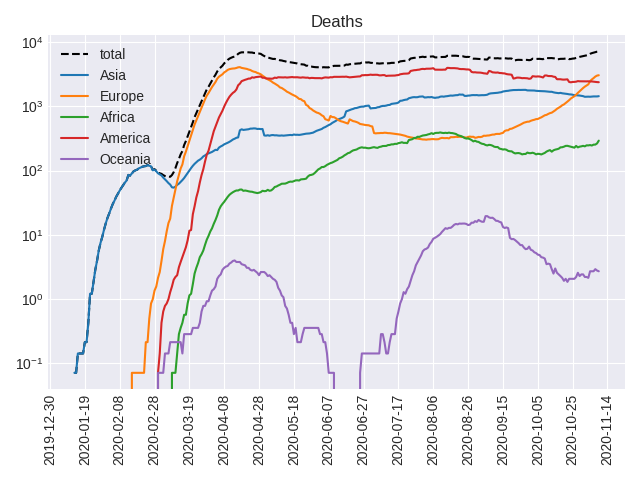

In [6]:
f, ax = plt.subplots()
deaths =ecdc.df.groupby('dateRep').agg({'deaths':'sum'})
ax.plot(deaths.index, deaths.deaths.rolling(14).mean(), label='total', c='k', linestyle='--')
continents = ecdc.df.continentExp.unique()
for c in continents:
    if c=='Other': continue
    df_deaths =ecdc.df[ecdc.df.continentExp==c].groupby('dateRep').agg({'deaths':'sum'})
    ax.plot(df_deaths.index, df_deaths.deaths.rolling(14).mean(), label=c.replace('_',' '))
    
    
pretty_plot(ax, log=True,title='Deaths')

# Austria, USA, India, UK, Netherlands and Germany

## Comparison - cumulative number for 14 days of cases per 100000

<IPython.core.display.Javascript object>


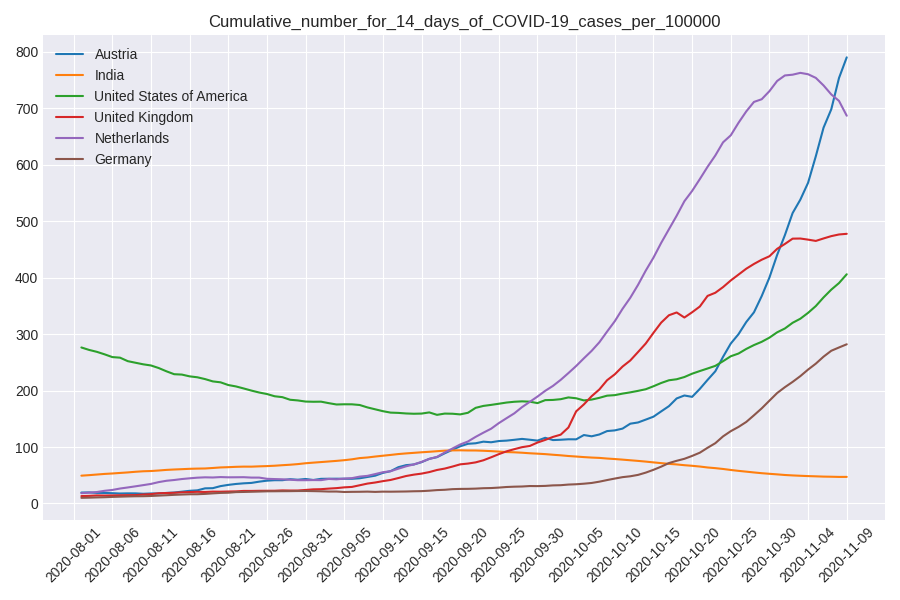

dateRep          cases  \
                             latest    rolling_avg   
countriesAndTerritories                              
United_States_of_America 2020-11-09  109184.142857   
India                    2020-11-09   46334.857143   
United_Kingdom           2020-11-09   22442.714286   
Germany                  2020-11-09   18120.142857   
Netherlands              2020-11-09    7162.285714   
Austria                  2020-11-09    5914.000000   

                                                                          \
                                                     last_5_days     max   
countriesAndTerritories                                                    
United_States_of_America  102507, 122436, 130623, 121413, 110693  130623   
India                          50210, 47638, 50356, 45674, 45903   97894   
United_Kingdom                 25177, 24138, 23287, 24957, 20572   26687   
Germany                        19990, 21506, 23399, 16017, 13363   23399   
Netherlands                         7622, 6957, 7232, 6659, 5659   11102   
Austria                             6514, 7051, 6324, 7898, 6006    7898   

                          deaths                              \
                             sum last_7_days_sum rolling_avg   
countriesAndTerritories                                        
United_States_of_America  237572            6576  939.428571   
India                     126611            4004  572.000000   
United_Kingdom             49044            2327  332.428571   
Germany                    11352             822  117.428571   
Netherlands                 7994             570   81.428571   
Austria                     1335             221   31.571429   

                                                             \
                                          last_5_days   max   
countriesAndTerritories                                       
United_States_of_America  1102, 1208, 1162, 1014, 459  4928   
India                         704, 670, 577, 559, 490  2003   
United_Kingdom                492, 378, 355, 413, 156  1224   
Germany                         118, 166, 130, 63, 63   315   
Netherlands                      106, 87, 118, 73, 44   234   
Austria                            35, 47, 44, 23, 17    47   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
United_States_of_America                                         405.842717           
India                                                             47.108434           
United_Kingdom                                                   477.459548           
Germany                                                          281.864874           
Netherlands                                                      686.534434           
Austria                                                          789.860901           

                                      
                                 max  
countriesAndTerritories               
United_States_of_America  405.842717  
India                      94.173835  
United_Kingdom            477.459548  
Germany                   281.864874  
Netherlands               762.410353  
Austria                   789.860901

In [7]:
# countries = ['AT', 'IN', 'US', 'UK', 'DE', 'NL', 'FR',  'IT', 'ES','EL' ]
countries = ['AT', 'IN', 'US', 'UK', 'NL', 'DE']
SELECTION =  ecdc.df[ecdc.df.geoId.isin(countries)]

ecdc.plot_comparison(countries, log=False, ndays=100)
ecdc.overview(SELECTION)


## Deaths

<IPython.core.display.Javascript object>


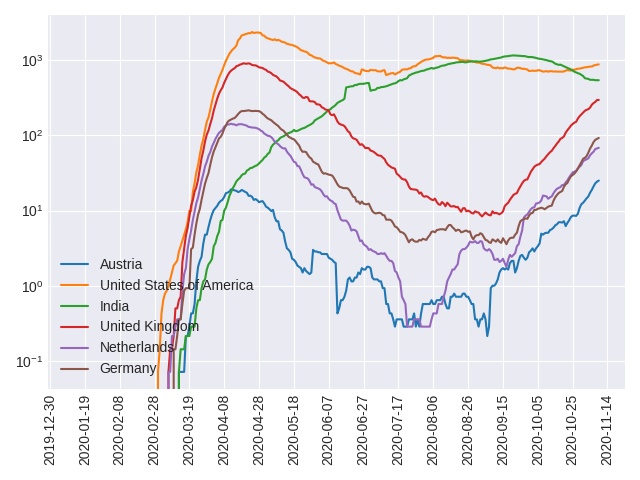

In [9]:
f,ax = plt.subplots()
countries = ('AT', 'US', 'IN', 'UK', 'NL', 'DE')
for c in countries:
    df = ecdc.select_country(c)
    popData2019 = df.iloc[0].popData2019
    label = df.iloc[0].countriesAndTerritories.replace('_',' ')

    ax.plot(df.dateRep, df.deaths.rolling(14).mean(), label=label)

pretty_plot(ax,log=True)

## Cases

<IPython.core.display.Javascript object>


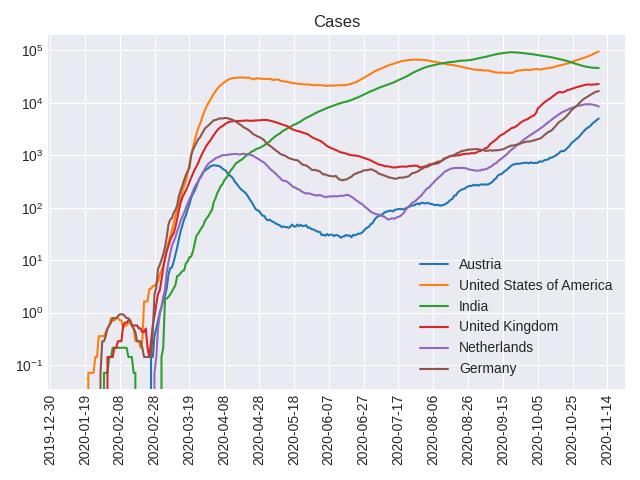

In [10]:
f,ax = plt.subplots()
countries = ('AT', 'US', 'IN', 'UK', 'NL', 'DE')
for c in countries:
    df = ecdc.select_country(c)
    popData2019 = df.iloc[0].popData2019
    label = df.iloc[0].countriesAndTerritories.replace('_',' ')

    ax.plot(df.dateRep, df.cases.rolling(14).mean(), label=label)

pretty_plot(ax,log=True,title='Cases')

# Sweden and the world

<IPython.core.display.Javascript object>


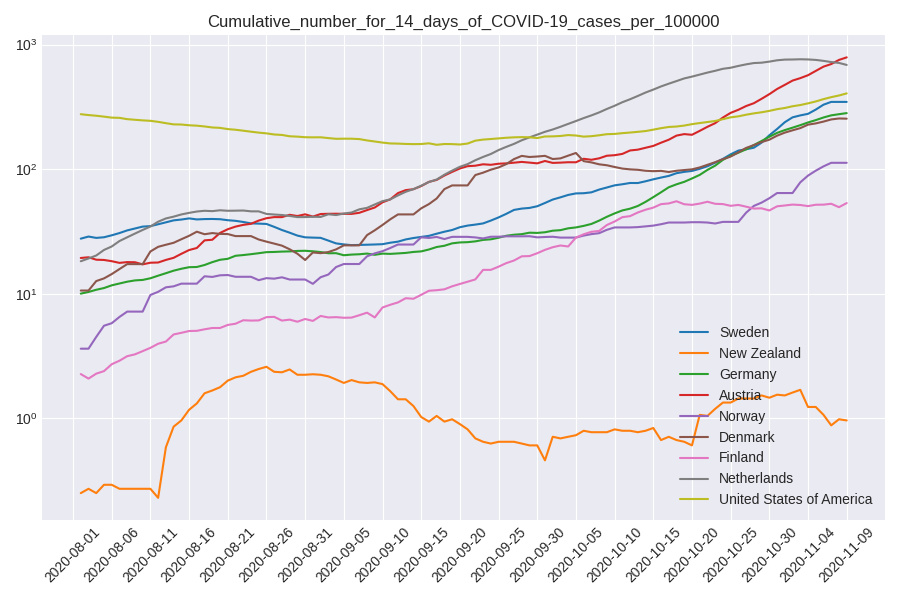

<AxesSubplot:title={'center':'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'}>

In [11]:
countries = ('SE', 'NZ','DE','AT','NO','DK','FI','NL','US')
ecdc.plot_comparison(countries, log=True, ndays=100)


# Europe

## Fastest growing number of cases per 100,000

<IPython.core.display.Javascript object>


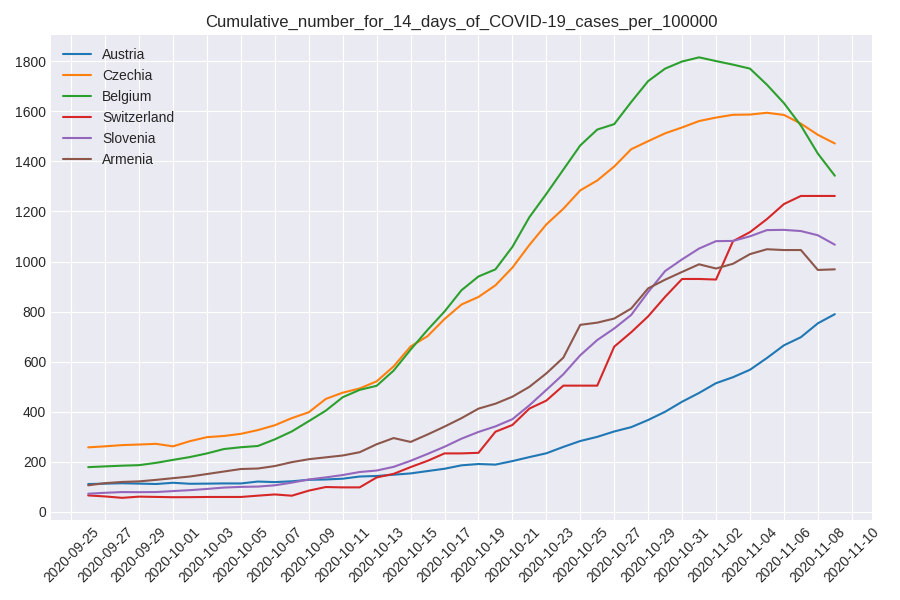

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
13167,2020-11-09,9,11,2020,3608,177,Czechia,CZ,CZE,10649800.0,Europe,1471.680219
4857,2020-11-09,9,11,2020,9,26,Belgium,BE,BEL,11455519.0,Europe,1342.854916
47826,2020-11-09,9,11,2020,0,0,Switzerland,CH,CHE,8544527.0,Europe,1262.059328
45123,2020-11-09,9,11,2020,890,4,Slovenia,SI,SVN,2080908.0,Europe,1067.370590
2046,2020-11-09,9,11,2020,1042,21,Armenia,AM,ARM,2957728.0,Europe,968.851767
17949,2020-11-09,9,11,2020,38619,270,France,FR,FRA,67012883.0,Europe,968.197414
2899,2020-11-09,9,11,2020,6006,17,Austria,AT,AUT,8858775.0,Europe,789.860901
39994,2020-11-09,9,11,2020,24785,236,Poland,PL,POL,37972812.0,Europe,770.912094
18978,2020-11-09,9,11,2020,2927,24,Georgia,GE,GEO,3996762.0,Europe,760.040253
12141,2020-11-09,9,11,2020,2543,42,Croatia,HR,HRV,4076246.0,Europe,757.240853


In [12]:
EU_med = EU[EU.popData2019>2000000]
EU_most = EU_med.sort_values(['dateRep', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'], ascending=[False,False]).head(10)

geoIds = EU_med.sort_values(['dateRep', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'], ascending=[False,False]).head(5).geoId.to_list()

ecdc.plot_comparison(['AT', *geoIds ], log=False, ndays=45, field='Cumulative_number_for_14_days_of_COVID-19_cases_per_100000');
EU_most


## Most deaths

['IT', 'RU', 'FR', 'PL', 'CZ']


<IPython.core.display.Javascript object>


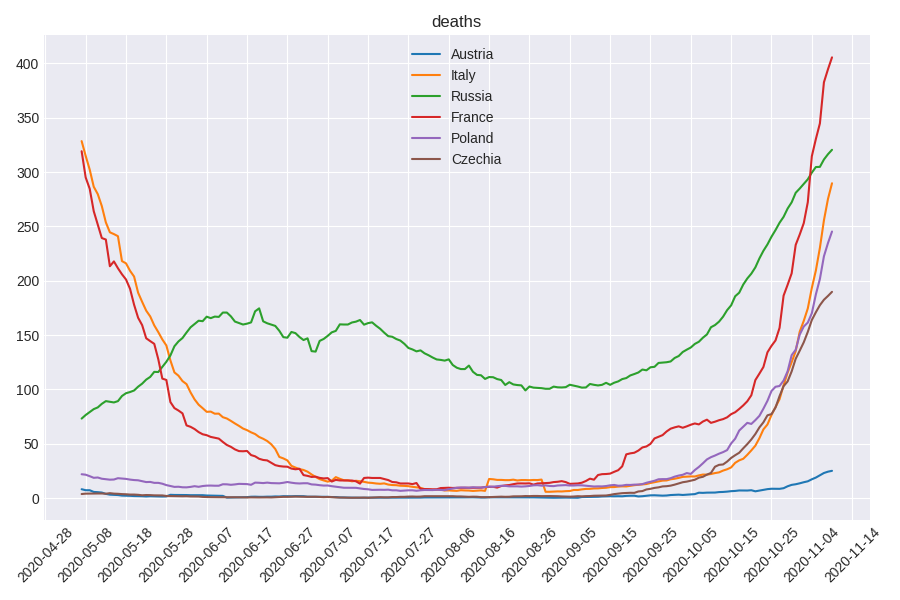

In [13]:
geoIds = EU_med.sort_values(['dateRep', 'deaths'], ascending=[False,False]).head(5).geoId.to_list()
print(geoIds)
ecdc.plot_comparison(['AT', *geoIds ], log=False, ndays=200, field='deaths', roll_days=14);



# Commit and Push

In [ ]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


In [41]:
! git push --set-upstream origin feature/angular


Branch 'feature/angular' set up to track remote branch 'feature/angular' from 'origin'.
Everything up-to-date
